In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model

from keras_ssd7 import build_model
from keras_ssd_loss import SSD_Loss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y
from ssd_batch_generator import parse_CSV, generate_batch

Using TensorFlow backend.


In [2]:
### Set up the model

# 1: Set some necessary parameters

img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class
min_scale=0.1 # The scaling factor for the smallest anchor boxes
max_scale=0.8 # The scaling factor for the largest anchor boxes
scales=[0.08, 0.16, 0.32, 0.64] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios=[0.5, 1, 2] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1=True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes=True # Whether or not you want to limit the boxes to lie entirely within the image boundaries

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `classifier_sizes` is needed below to set up `SSDBoxEncoder`
model, classifier_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                      n_classes=n_classes,
                                      min_scale=min_scale,
                                      max_scale=max_scale,
                                      scales=scales,
                                      aspect_ratios=aspect_ratios,
                                      two_boxes_for_ar1=two_boxes_for_ar1,
                                      limit_boxes=limit_boxes)
model.load_weights('./model_4_weights.h5')
#model = load_model('./model_0.h5')

In [3]:
### Set up training

batch_size = 40

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSD_Loss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes,
                                classifier_sizes=classifier_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords='centroids')

# 5: Create the batch generator

filenames, labels = parse_CSV('./data/labels.csv', n_classes)

train_generator = generate_batch(filenames=filenames,
                                 labels=labels,
                                 path_prefix='./data/',
                                 batch_size=batch_size,
                                 train=True,
                                 ssd_box_encoder=ssd_box_encoder,
                                 crop=False,
                                 resize=False,
                                 gray=False,
                                 equalize=False,
                                 brightness=(0.5, 2, 0.5),
                                 flip=0.5,
                                 translate=((5, 50), (3, 30), 0.5),
                                 scale=(0.75, 1.3, 0.5),
                                 limit_boxes=True,
                                 include_thresh=0.4,
                                 diagnostics=False)

In [7]:
### Run training

# 6: Run training

epochs = 2

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = (int(len(filenames)/batch_size)+1)*4,
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./model_4_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='loss',
                                                         min_delta=0.0005,
                                                         patience=7),
                                           ReduceLROnPlateau(monitor='loss',
                                                             factor=0.5,
                                                             patience=5,
                                                             epsilon=0.0005,
                                                             cooldown=0)])

model_name = 'model_4'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

Epoch 1/2
2192/2192 [==============================] - 1143s - loss: 0.0399  
Epoch 2/2
2192/2192 [==============================] - 1146s - loss: 0.0405  

Model saved as model_4.h5
Weights also saved separately as model_4_weights.h5



In [4]:
### Make predictions

# 1: Create a generator to provide samples

predict_generator = generate_batch(filenames=filenames,
                                   labels=labels,
                                   path_prefix='./data/',
                                   batch_size=1,
                                   train=False,
                                   crop=False,
                                   resize=False,
                                   gray=False,
                                   equalize=False,
                                   brightness=False,
                                   flip=False,
                                   translate=False,
                                   scale=False,
                                   limit_boxes=True,
                                   include_thresh=0.4,
                                   diagnostics=False)

In [20]:
X, y_true = next(predict_generator)

In [21]:
y_pred = model.predict(X)

In [22]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [23]:
print(y_pred.shape)

y_pred_converted = np.copy(y_pred[:,:,-9:-4]) # Slice out the four offset predictions plus one element where we'll write the class IDs in the next step
y_pred_converted[:,:,0] = np.argmax(y_pred[:,:,:-8], axis=-1)

print(np.sum(y_pred_converted[0,:,0]))

np.set_printoptions(suppress=True, precision=3)
print(y_pred[y_pred[:,:,1] > 0.5])

(1, 10316, 10)
16.0
[[   0.141    0.859    0.204    0.037    0.327    0.131  281.     305.
   138.     162.   ]
 [   0.033    0.967    0.404    0.012    0.187    0.036  277.     309.
   134.     166.   ]
 [   0.396    0.604    0.374    0.27     0.139    0.359  277.     309.
   142.     158.   ]
 [   0.045    0.955   -0.17     0.101    0.525    0.103  290.     314.
   138.     162.   ]
 [   0.006    0.994    0.062    0.056    0.196   -0.021  286.     318.
   134.     166.   ]
 [   0.1      0.9      0.169    0.336    0.452    0.336  286.     318.
   142.     158.   ]
 [   0.443    0.557   -0.175    0.111    0.342    0.021  294.     326.
   134.     166.   ]
 [   0.458    0.542   -0.213   -0.103    0.299    0.027  314.     338.
   138.     162.   ]
 [   0.208    0.792    0.216   -0.228    0.11    -0.31   277.     309.
   142.     174.   ]
 [   0.119    0.881   -0.008   -0.209    0.152   -0.258  286.     318.
   142.     174.   ]
 [   0.326    0.674    0.13    -0.282   -0.062   -0.706  276

In [36]:
y_pred_decoded = decode_y(y_pred, confidence_thresh=0.5)

batch_item.shape: (10316, 6)
boxes.shape: (16, 6)
boxes.shape: (16, 6)


In [37]:
print(y_pred_decoded)

[array([[ 309.121,  310.945,  191.395,  184.616,    1.   ,    0.859],
       [ 331.171,  311.015,  161.554,  172.123,    1.   ,    0.967],
       [ 330.094,  351.641,  163.121,  226.229,    1.   ,    0.604],
       [ 266.589,  330.363,  233.321,  179.641,    1.   ,    0.955],
       [ 294.345,  327.258,  162.987,  162.62 ,    1.   ,    0.994],
       [ 310.06 ,  371.127,  223.051,  221.158,    1.   ,    0.9  ],
       [ 270.59 ,  344.456,  188.64 ,  169.499,    1.   ,    0.557],
       [ 284.675,  321.271,  186.087,  166.362,    1.   ,    0.542],
       [ 307.634,  269.249,  158.465,  127.617,    1.   ,    0.792],
       [ 284.911,  281.583,  165.318,  134.473,    1.   ,    0.881],
       [ 293.607,  272.442,  126.929,   90.352,    1.   ,    0.674],
       [ 415.393,  463.163,  186.014,  145.382,    1.   ,    0.726],
       [ 411.267,  478.165,  132.635,  182.176,    1.   ,    0.701],
       [ 417.67 ,  471.37 ,  133.388,  212.593,    1.   ,    0.642],
       [  12.643,   95.308,  137.

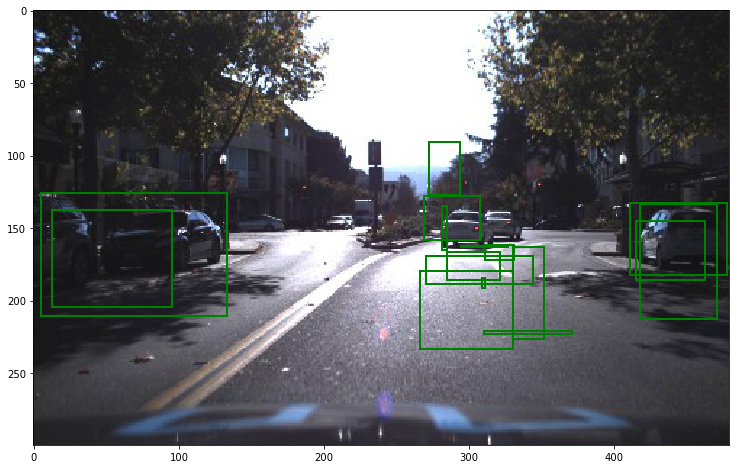

In [38]:
plt.figure(figsize=(16,8))
plt.imshow(X[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    current_axis.add_patch(plt.Rectangle((box[0], box[2]), box[1]-box[0], box[3]-box[2], color='green', fill=False, linewidth=2))

In [19]:
arr = np.random.randint(10, size=(2,3,2))
arr2 = np.random.randint(10, size=(2,3,3))
print("arr:", arr)
ind = np.random.randint(1, size=(2,3,2))

i0, i1, i2 = np.indices(arr.shape)
print(i0.shape)

newarr = arr[i0,i1,ind]

print("newarr:", newarr)

arr: [[[6 5]
  [4 1]
  [1 8]]

 [[0 7]
  [9 9]
  [1 1]]]
(2, 3, 2)
newarr: [[[6 6]
  [4 4]
  [1 1]]

 [[0 0]
  [9 9]
  [1 1]]]
